# Estimating Seasonalities with Shabadoo

This notebook builds and explores a Shabadoo model to predict very seasonal data: avg temperature in central park in NYC. Enjoy friends :-).

In [2]:
import numpy as np
import pandas as pd
from numpyro import distributions as dist
import shabadoo

import matplotlib.pyplot as plt

## The data

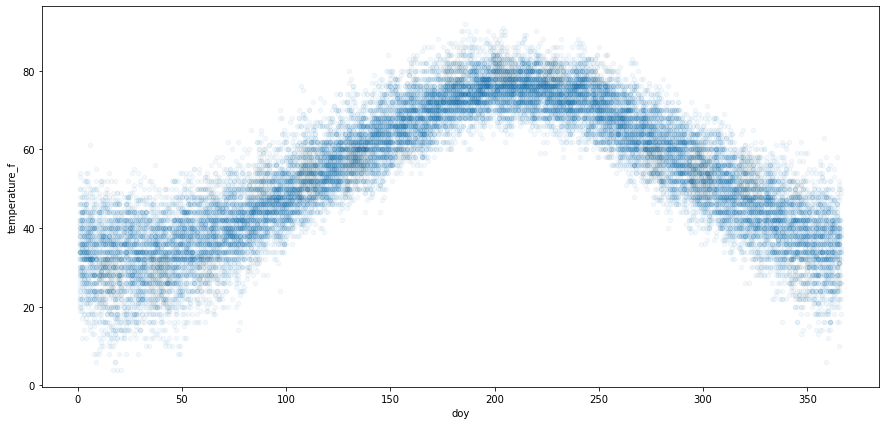

In [3]:
df = (
    pd.read_csv('data/nyc_weather.csv.gz')
    .assign(Date=lambda x: pd.to_datetime(x.Date))
    .loc[lambda x: pd.notnull(x).all(axis=1)]
    
    # no leap years
    .loc[lambda x: ~((x.Date.dt.month == 2) & (x.Date.dt.day == 29))]
)

fig, ax = plt.subplots(figsize=(15, 7))

(
    df.assign(year=lambda x: x.Date.dt.year, doy=lambda x: x.Date.dt.dayofyear)
    .groupby("year")
    .plot("doy", "temperature_f", ax=ax, alpha=0.05, legend=False, kind="scatter")
)

None

## Specifying and fitting the model

For this model I will assume that temperatures seasonally vary at a 1 year cadence, so each day $d$ has a seasonality value which additively combines with the intercept.

$$
\text{temperature} \sim Normal(\text{Intercept} + \text{Seasonality}_d, \sigma)
$$

For priors, we can expect the $\text{Intercept}$ to live somewhere around the average temperature. I checked and it is about 54 degrees.

Shabadoo implements frequency domain seasonality, which is also implemented in [statsmodels](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_seasonal.html) and [prophet](https://github.com/facebook/prophet/blob/1053a6e9ce935ff29c8f69f56d0a6b3c3397520e/python/fbprophet/forecaster.py#L416), the latter of which Shabadoo copies very shamelessly. Seasonality is implemented by generating a _fourier series_, that is, many possible repeating patterns that are zero-sum within a given period. 

Below, I specify a seasonality for timestamps in the column `Date`. I set the period to 365.2422 days (1 year) and the `fourier_order` to 3. The final parameter can be set to higher values to fit more complex seasonalities, but is prone to overfitting. By default, seasonality has a prior of $N(0, 1)$, but I override the default because we know seasonal variation in temperature is greater than that.


In [4]:
class Model(shabadoo.Normal):
    dv = "temperature_f"

    features = dict(const=dict(transformer=1, prior=dist.Normal(54, 1)))
    seasonality = dict(
        annual=dict(period=365.2422, series_order=3, col="Date", prior=dist.Normal(0, 10))
    )


RNG_KEY = np.array([0, 1])

model = Model().fit(df, rng_key=RNG_KEY, num_samples=1000, num_warmup=1000)

sample: 100%|██████████| 2000/2000 [00:12<00:00, 165.84it/s, 3 steps of size 6.50e-01. acc. prob=0.91]


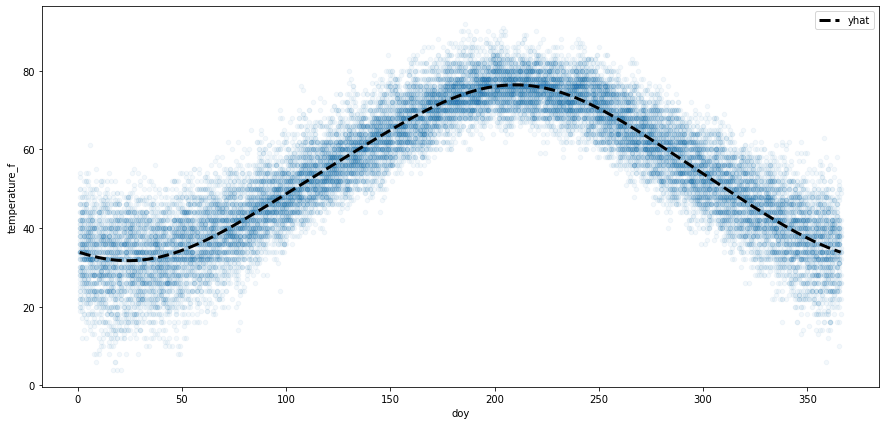

In [5]:
fig, ax = plt.subplots(figsize=(15, 7))

(
    df.assign(year=lambda x: x.Date.dt.year, doy=lambda x: x.Date.dt.dayofyear)
    .groupby("year")
    .plot("doy", "temperature_f", ax=ax, alpha=0.05, legend=False, kind="scatter")
)

pred = pd.DataFrame(dict(Date=pd.date_range("2020-01-01", "2020-12-31"))).assign(
    yhat=model.predict, doy=lambda x: x.Date.dt.dayofyear
)

pred.plot("doy", "yhat", ax=ax, linestyle="--", color="black", linewidth=3)

None


## What has the model learned?

The frequency domain seasonality will generate several possible cycles that repeat over the length of 365.2422 days. The model additively weighs each of these based on how well they match the data.

You can get a sense of which cycles are important based on which coefficients are more-nonzero.

In [6]:
print(model.formula)

temperature_f = (
    const * 54.07339(+-0.04206)
  + annual__0 * -8.78942(+-0.05944)
  + annual__1 * -19.85373(+-0.06083)
  + annual__2 * 0.22566(+-0.05988)
  + annual__3 * -0.29400(+-0.05873)
  + annual__4 * -0.62543(+-0.06366)
  + annual__5 * -0.15370(+-0.06088)
)


Series 1 seems to be the most critical, followed by series 0.

Taking it a step further, we can plot each of the cycles over the course of one year. The model's `transform_seasonality` method can be helpful when inspecting learned seasons.

<AxesSubplot:xlabel='Date'>

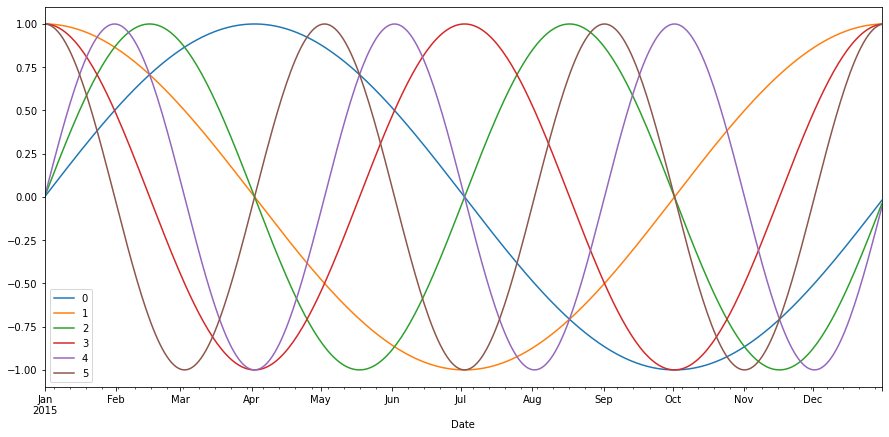

In [7]:
df_2015 = df.loc[lambda x: x.Date.dt.year == 2015]

cycles = pd.DataFrame(model.transform_seasonality(df_2015)['annual'], index=df_2015.Date)
cycles.plot(figsize=(15, 7))


Each of those cycles are multiplied by a coefficient and then summed for each input passed through the model. The summed season is what we add to the intercept to produce a final prediction about the temperature in NYC.

<AxesSubplot:xlabel='Date'>

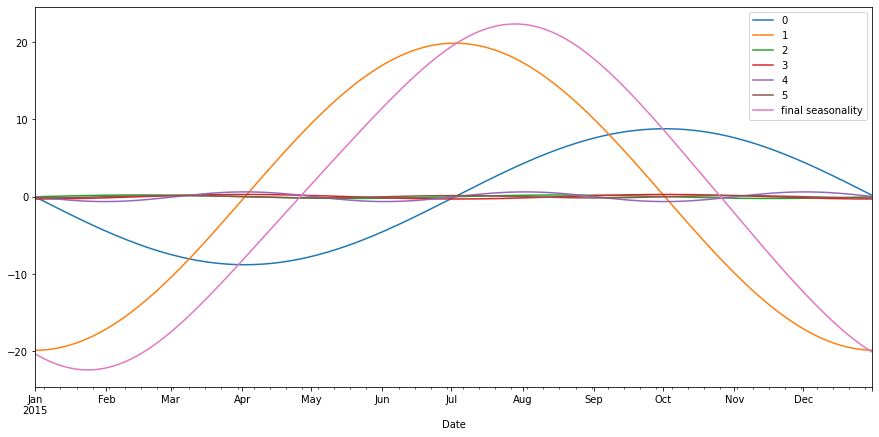

In [8]:
avg_coefs = model.samples_flat['annual'].mean(axis=0)
seasons = cycles * avg_coefs
seasons['final seasonality'] = seasons.sum(axis=1)

seasons.plot(figsize=(15, 7))

From the final seasonality, we learn that  peak seasonal temperatures occur in July and August and are about 20 degrees fahrenheit greater than the average annual temperature.

In [10]:
model.samples.keys()


dict_keys(['_sigma', 'annual', 'const'])

In [15]:
import json
Model.from_dict(json.loads(model.to_json()))


IncompleteSamples: IncompleteSamples(No or not enough samples found for `annual`.)

In [16]:
json.loads(model.to_json())

3.99298095703125,
    54.12511444091797,
    54.10388946533203,
    54.06377410888672,
    54.031044006347656,
    54.0666618347168,
    54.087039947509766,
    54.08185577392578,
    54.07191467285156,
    54.0355339050293,
    54.07863235473633,
    54.056297302246094,
    53.95456314086914,
    54.154632568359375,
    54.09507751464844,
    54.086055755615234,
    54.09733581542969,
    54.09190368652344,
    54.09394454956055,
    54.05928421020508,
    54.097286224365234,
    54.097591400146484,
    54.15522003173828,
    53.99601745605469,
    54.10441207885742,
    54.05876922607422,
    54.141658782958984,
    54.06344223022461,
    54.0156364440918,
    54.12895202636719,
    54.0435791015625,
    54.074825286865234,
    54.06847381591797,
    54.174781799316406,
    53.96373748779297,
    54.170955657958984,
    53.97431182861328,
    53.99099349975586,
    54.12752151489258,
    54.026763916015625,
    54.123863220214844,
    54.074432373046875,
    54.11819839477539,
    54